# Region of Interest Analyse

### module importieren

In [1]:
import glob

import numpy as np
import pandas as pd
from sklearn import preprocessing

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### fMRT-Daten

In [2]:
fmri_img_list = glob.glob('../data/sub-01_task-imagery_run-0*_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
fmri_img_list.sort()
fmri_img_list = fmri_img_list[1:]
fmri_imgs = image.concat_imgs(fmri_img_list)

### Design

In [3]:
onset_csvs = glob.glob('../data/sub-01_task-imagery_run-0*_events.tsv')
onset_csvs.sort()
onset_csvs = onset_csvs[1:]

In [4]:
def make_onsets(csv_file):
    
    df = pd.read_csv(csv_file,sep='\t')
    df.loc[:,'trial_num'] = [('0%s'%x)[-2:] for x in df.index.get_values().astype(str)]
    df.loc[:,'trial_type'] = df.loc[:,'trial_domain']
    
    return df

In [5]:
n_volumes = image.load_img(fmri_img_list[-1]).shape[-1]
my_tr = 3
my_duration = n_volumes*my_tr

In [6]:
def make_design(df,my_tr=my_tr,my_duration=my_duration):
    frame_times = np.arange(0,my_duration,my_tr)
    design_matrix = first_level_model.make_first_level_design_matrix(frame_times=frame_times,
                                                                     events=df,
                                                                     period_cut=300,
                                                                    )
    return design_matrix

In [7]:
def make_big_design(onset_csvs):
    
    design_matrix = pd.DataFrame()
    for run_num,onset_csv in enumerate(onset_csvs):
        this_onset = make_onsets(onset_csv)
        this_design = make_design(this_onset)
        this_design.index = this_design.index+my_duration*run_num
        this_design.columns = ['%s-run%s'%(c,run_num+1) for c in this_design.columns]

        design_matrix = pd.concat([design_matrix, this_design],sort=False)
        design_matrix = design_matrix.fillna(0)

    return design_matrix

In [8]:
design_matrix = make_big_design(onset_csvs)

/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


### Daten und Design im Modell

In [9]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             smoothing_fwhm=6, # hier auswählen,
                                            )
fmri_glm = fmri_glm.fit(fmri_imgs,design_matrices=design_matrix)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


## Ergebnisse berechnen

In [10]:
n_runs = len(fmri_img_list)
design_matrix = fmri_glm.design_matrices_[-1]
n_cols = design_matrix.shape[1]
n_conditions = int(n_cols/n_runs)

In [11]:
cond_names = np.unique([x.split('-')[0] for x in design_matrix.columns if 'drift' not in x and 'constant' not in x])

conditions = {}
for i,cond in enumerate(cond_names):
    this_array = np.zeros(n_conditions)
    this_array[i] = 1
    conditions[cond] = np.array(list(this_array)*n_runs)

In [12]:
def show_conds(conditions):
    con_df = pd.DataFrame(conditions,index=design_matrix.columns).T
    plt.figure(figsize=(24,4))
    sns.heatmap(con_df,
                square=True,cbar=False,cmap='Greys_r',annot=True);
    plt.show()

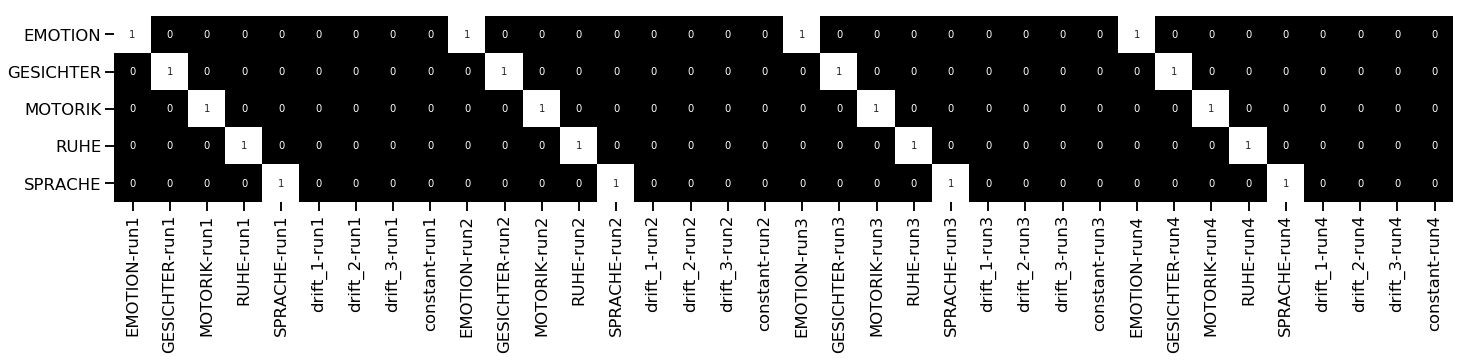

In [13]:
show_conds(conditions)

### Einen Kontrast definieren

In [14]:
def make_contrasts(c,conditions=conditions):
    
    # gewichte der gewählten bedingung
    this_condition = conditions[c]
    # alle anderend bedingungen
    other_conditions = [x for x in conditions.keys() if x!=c]

    # leerer array für die summe der gewichte der anderen bedingungen
    others = np.zeros(this_condition.shape[0])
    # für jede der anderen bedingungen
    for o in other_conditions:
        # addiere die gewichte der bedingung
        others += conditions[o]
    # teile die summe der gewichte durch die anzahl der bedingungen
    others = others/len(other_conditions)
    
    # gewählte bedingung minus mittel aller anderen
    contrast = this_condition - others
    
    return contrast

In [15]:
contrasts = {}
for c in conditions:
    contrasts[c] = make_contrasts(c)

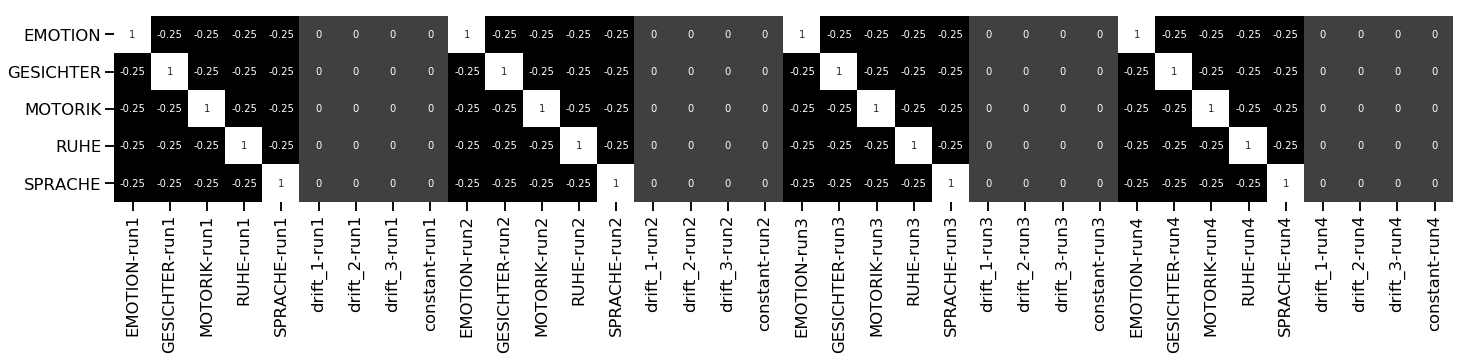

In [16]:
show_conds(contrasts)

### Ergebniskarten generieren

In [17]:
result_maps = {}
for c in contrasts:
    contrast = contrasts[c]
    result_maps[c] = fmri_glm.compute_contrast(contrast,
                                               output_type='z_score' # art des outputs hier auswählen
                                               )

Dictionary mit Ergebniskarten

In [18]:
result_maps

{'EMOTION': <nibabel.nifti1.Nifti1Image at 0x7f30a2b697f0>,
 'GESICHTER': <nibabel.nifti1.Nifti1Image at 0x7f30a2b69e48>,
 'MOTORIK': <nibabel.nifti1.Nifti1Image at 0x7f30a2b698d0>,
 'RUHE': <nibabel.nifti1.Nifti1Image at 0x7f30a2b69550>,
 'SPRACHE': <nibabel.nifti1.Nifti1Image at 0x7f30a2b69630>}

Ergebniskarten visualisieren

/opt/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


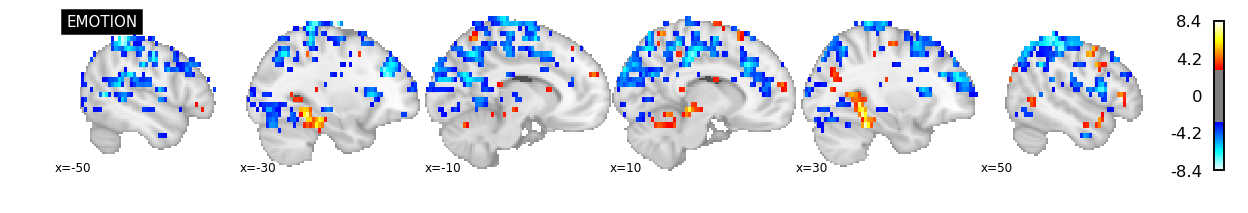

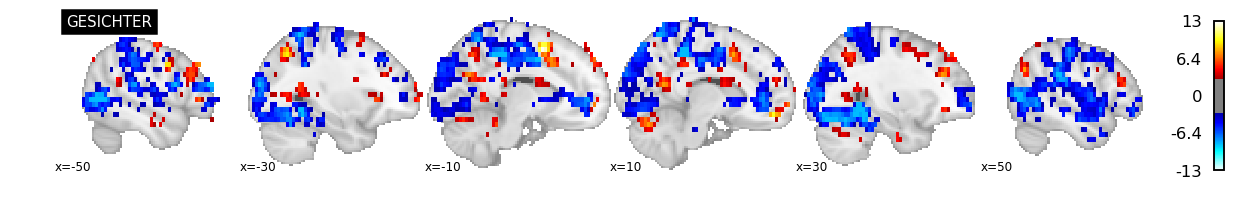

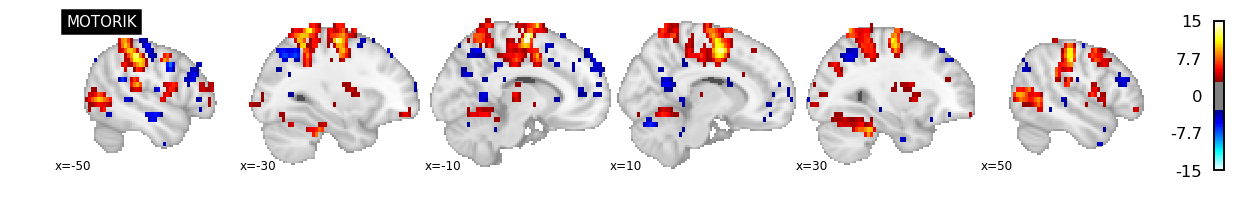

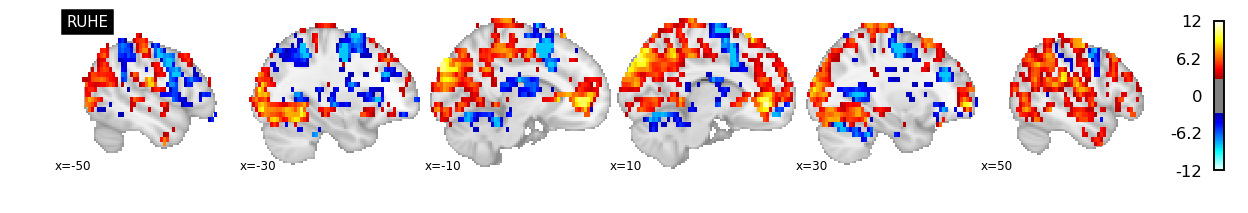

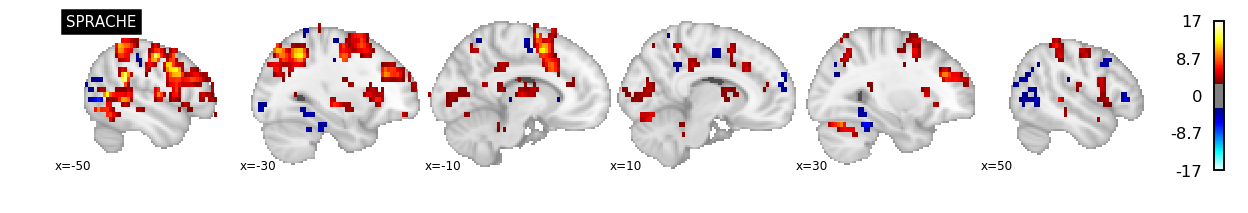

In [19]:
for c in result_maps:
    im = result_maps[c]
    plotting.plot_stat_map(im,threshold=3,display_mode='x',cut_coords=range(-50,51,20),title=c)
    plt.show()

## Daten aus anatomischen Regionen extrahieren

In [20]:
from nilearn import datasets

Die Atlaskarte

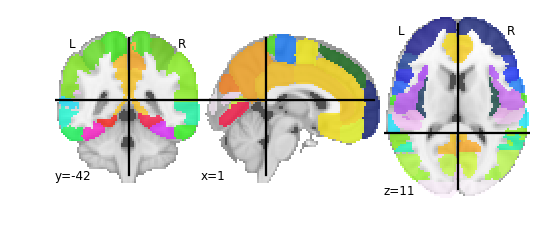

In [21]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm',symmetric_split=True)
plotting.plot_roi(atlas['maps'])

Die Regionen die im Atlas enthalten sind auflisten

In [22]:
pd.DataFrame(atlas['labels'])

,0
0,Background
1,Left Frontal Pole
2,Right Frontal Pole
3,Left Insular Cortex
4,Right Insular Cortex
5,Left Superior Frontal Gyrus
6,Right Superior Frontal Gyrus
7,Left Middle Frontal Gyrus
8,Right Middle Frontal Gyrus
9,"Left Inferior Frontal Gyrus, pars triangularis"


#### Den Atlas zum Extrahieren der Daten verwenden

In [23]:
atlas_masker = input_data.NiftiLabelsMasker(atlas['maps'],background_label=None).fit()

In [24]:
atlas_data = atlas_masker.transform(result_maps.values())
atlas_data_df = pd.DataFrame(atlas_data,columns=atlas['labels']).T
atlas_data_df.columns = result_maps.keys()

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [25]:
atlas_data_df.tail()

,EMOTION,GESICHTER,MOTORIK,RUHE,SPRACHE
Right Planum Temporale,-1.549785,-3.408368,0.408836,3.437917,1.038751
Left Supracalcarine Cortex,-2.441120,-2.927267,-0.698266,4.773446,1.173963
Right Supracalcarine Cortex,-1.904029,-3.658107,-0.332413,4.134398,1.678589
Left Occipital Pole,-2.147802,-3.248985,0.121862,4.876315,0.246827
Right Occipital Pole,-1.989672,-3.712740,0.431047,4.344774,0.810508


#### Die Daten in einer Abbildung visualisieren

Mittlere absolute Aktivität jeder Region

In [26]:
roi_order = abs(atlas_data_df).mean(axis=1).sort_values().index
idx = range(len(roi_order))

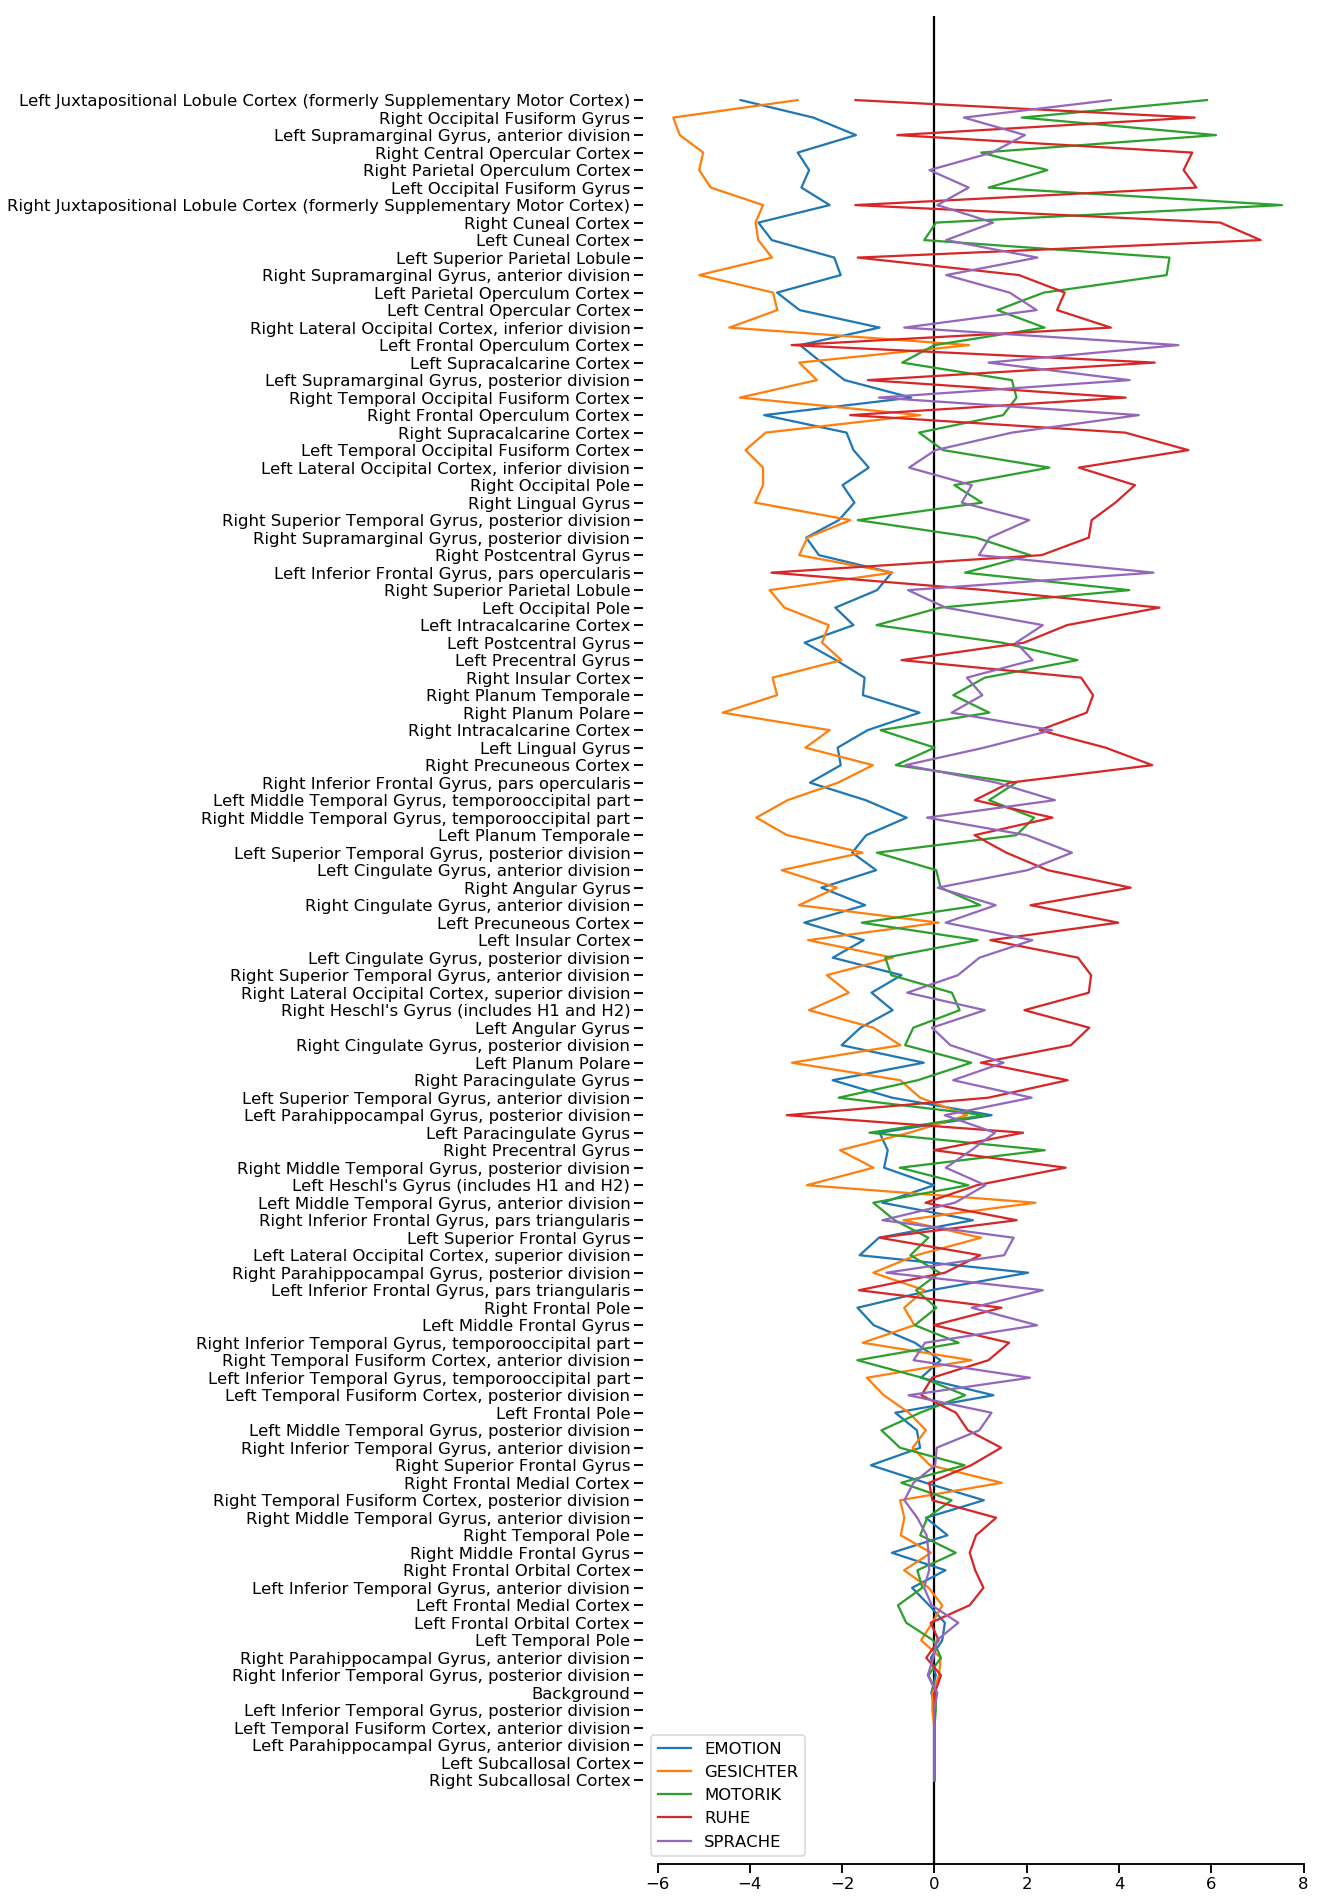

In [27]:
fig,ax = plt.subplots(1,1,figsize=(12,34))
for cond in atlas_data_df.columns:
    this_cond_data = atlas_data_df.loc[roi_order,cond]
    ax.errorbar(this_cond_data,idx,label=cond)
ax.set_yticks(idx)
ax.set_yticklabels(roi_order)
ax.axvline(0,color='k')
plt.legend()
sns.despine(left=True,trim=True)
plt.show()

In [28]:
atlas_im = atlas_masker.inverse_transform(atlas_data)

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


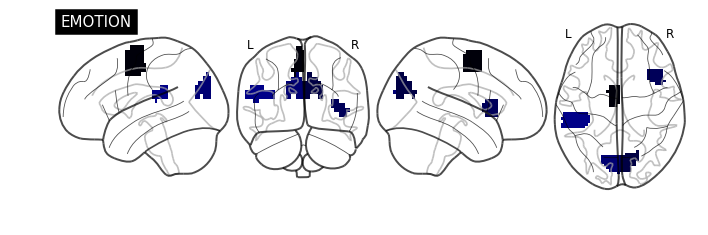

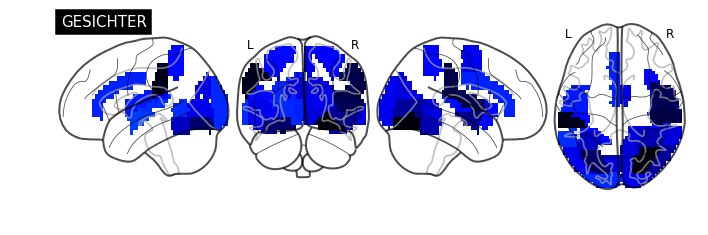

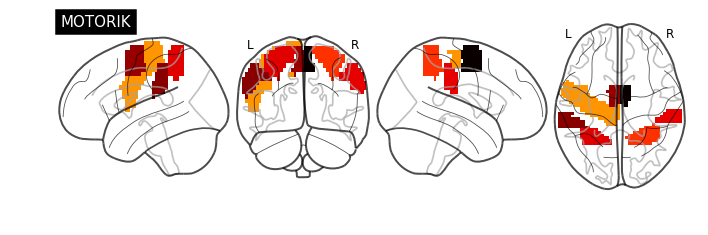

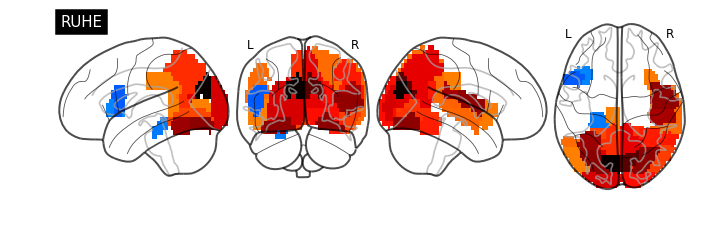

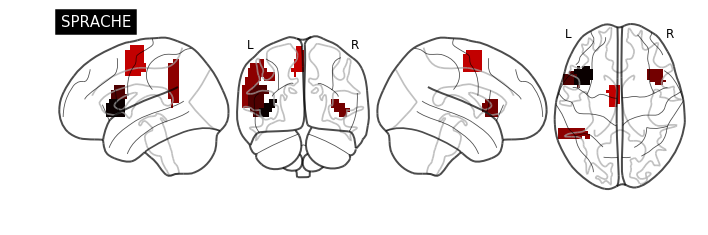

In [29]:
for i,c in enumerate(result_maps.keys()):
    plotting.plot_glass_brain(image.index_img(atlas_im,i),threshold=3,plot_abs=False,display_mode='lyrz',title=c)
    plt.show()

### Atlas mit L-R Differenzen

Funktion zum Splitten

In [30]:
split_str = lambda s: (s.split(' ')[0], ' '.join(s.split(' ')[1:]))

Anwendung der Funktion auf alle Elemente

In [31]:
new_idx = list(map(split_str,atlas_data_df.index))

Neue Tabelle

In [32]:
atlas_split_df = atlas_data_df.copy()
atlas_split_df.index = pd.MultiIndex.from_tuples(new_idx)
atlas_split_df = atlas_split_df.drop('Background')
atlas_split_df = atlas_split_df.unstack(0).sort_index(axis=1)

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [33]:
sprache_df = atlas_split_df.loc[:,'SPRACHE']
sprache_df

,Left,Right
Frontal Pole,1.237053,0.808427
Insular Cortex,2.121367,0.704435
Superior Frontal Gyrus,1.716946,0.016731
Middle Frontal Gyrus,2.223411,-0.127182
"Inferior Frontal Gyrus, pars triangularis",2.348370,-1.124514
"Inferior Frontal Gyrus, pars opercularis",4.746157,1.347586
Precentral Gyrus,2.127455,0.798550
Temporal Pole,0.052251,-0.168782
"Superior Temporal Gyrus, anterior division",2.106372,0.508743
"Superior Temporal Gyrus, posterior division",2.979903,2.051939


Sortieren nach Differenz

In [34]:
sprache_diff_order = (sprache_df.loc[:,'Left']-sprache_df.loc[:,'Right']).sort_values().index

In [35]:
sorted_sprache_df = sprache_df.loc[sprache_diff_order,:]
sorted_sprache_df.tail()

,Left,Right
Superior Parietal Lobule,2.230510,-0.571241
"Supramarginal Gyrus, posterior division",4.230288,1.198823
"Inferior Frontal Gyrus, pars opercularis",4.746157,1.347586
"Inferior Frontal Gyrus, pars triangularis",2.348370,-1.124514
Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),3.819779,0.063281


Plotten

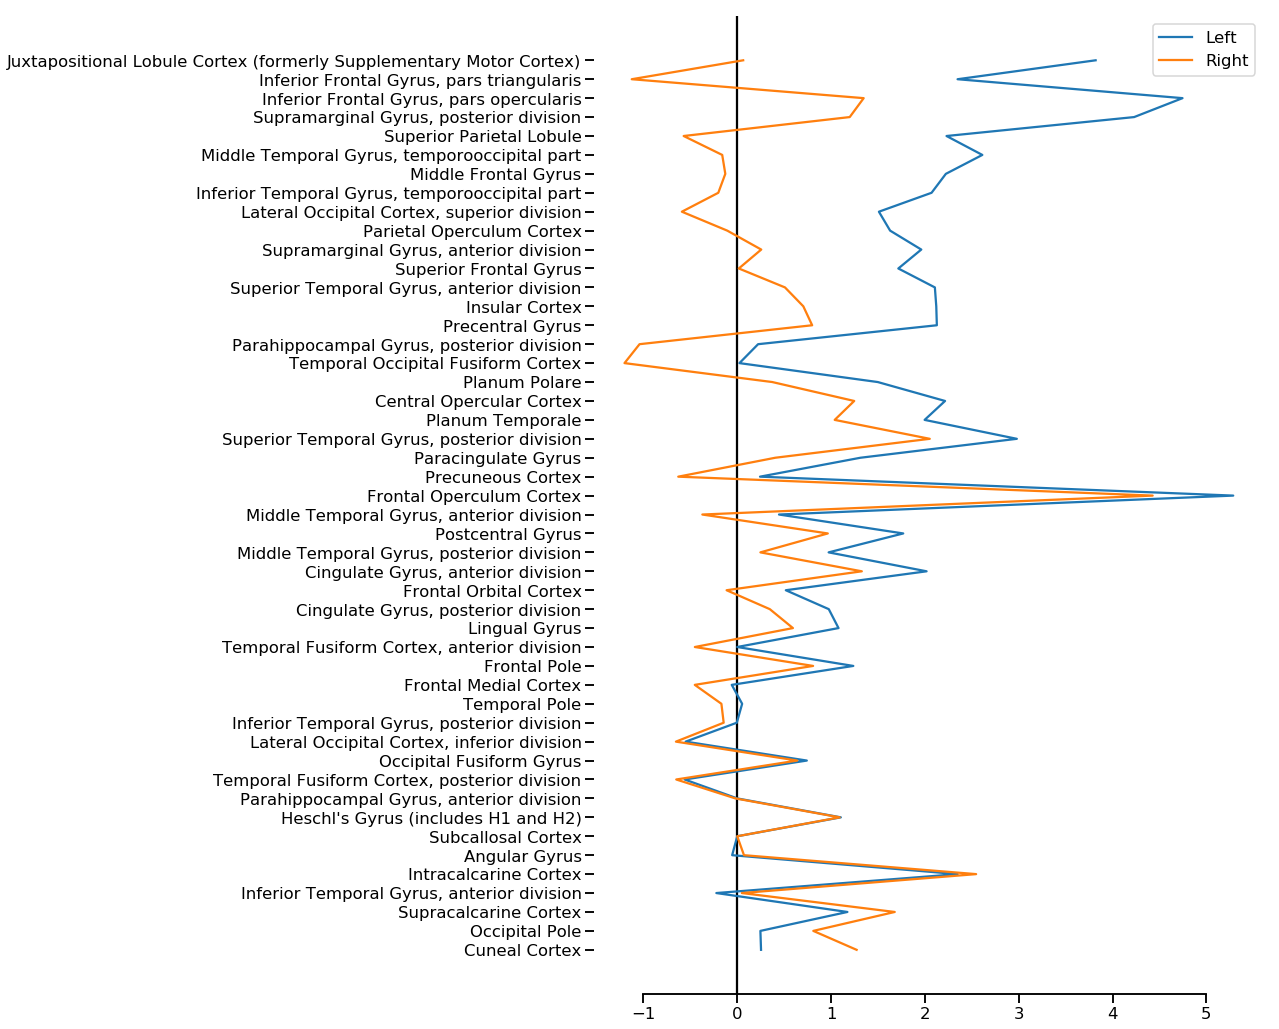

In [36]:
y_labels = sorted_sprache_df.index
y = range(len(y_labels))

fig,ax = plt.subplots(1,1,figsize=(12,18))
for c in sorted_sprache_df.columns:
    this_side_data = sorted_sprache_df.loc[:,c].values
    ax.errorbar(this_side_data,y,label=c)
ax.set_yticks(y)
ax.set_yticklabels(y_labels)
ax.axvline(0,color='k')
plt.legend()
sns.despine(left=True,trim=True)
plt.show()

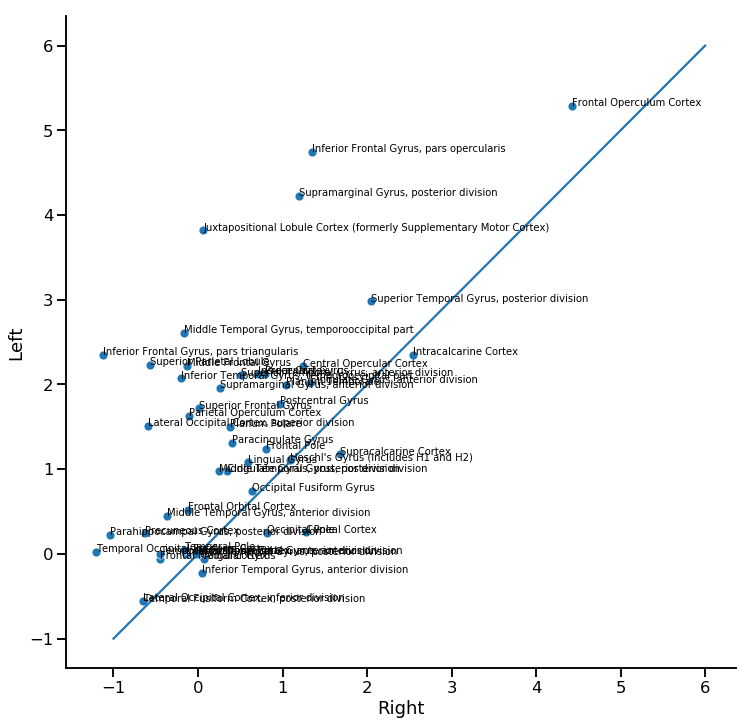

In [37]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
sns.scatterplot(data=sorted_sprache_df,y='Left',x='Right',ax=ax)
for i in sorted_sprache_df.index:
    this_df = sorted_sprache_df.loc[i,:]
    s = this_df.name
    x,y = this_df.values[::-1]
    plt.annotate(s,xy=(x,y))
plt.plot([-1,6],[-1,6])
sns.despine()
plt.show()